## Marketing - Zoho Campaign

In [19]:
import fitz  # PyMuPDF
from datetime import datetime
import re
import ipywidgets as widgets
from IPython.display import display

# Function to extract text sorted visually
def extract_text_sorted(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        blocks = page.get_text("blocks")  # Extract text blocks
        sorted_blocks = sorted(blocks, key=lambda b: (b[1], b[0]))  # Sort by y (top-to-bottom), then x
        for block in sorted_blocks:
            text = block[4]
            full_text += text + "\n"
    return full_text

# Normalize text to handle URLs spanning multiple lines
def normalize_text(text):
    lines = text.splitlines()
    normalized_lines = []
    current_url = ""
    for line in lines:
        if re.match(r"https?://", line.strip()):  # Start of a URL
            if current_url:
                normalized_lines.append(current_url)
            current_url = line.strip()
        elif current_url and line.strip():
            current_url += line.strip()
        else:
            if current_url:
                normalized_lines.append(current_url)
                current_url = ""
            normalized_lines.append(line)
    if current_url:
        normalized_lines.append(current_url)
    return "\n".join(normalized_lines)

# Function to get the current year and week
def get_year_and_week():
    now = datetime.now()
    year = now.strftime("%Y")
    week_of_year = now.strftime("%U")
    return year, week_of_year

# Function to process uploaded PDF and generate text output
def process_pdf(uploaded_file):
    full_text = extract_text_sorted(uploaded_file)
    input_text = normalize_text(full_text)

    # Extract required information using regular expressions
    campaign_name = re.search(r"Campaign:(.*)", input_text).group(1).strip()
    sent_on_date = re.search(r"Sent on :\s*(.*)", input_text).group(1).strip()
    emails_sent = re.search(r"(\d+)\s*emails sent", input_text).group(1).strip()
    delivered_percentage = re.search(r"Delivered (\d+\.\d+)%", input_text).group(1)
    delivered_contacts = re.search(r"(\d+) Contacts", input_text).group(1)
    unique_opens_percentage = re.search(r"Unique Opens (\d+\.\d+)%", input_text).group(1)
    unique_opens_contacts = re.findall(r"(\d+) Contacts", input_text)[2]
    unique_clicks_percentage = re.search(r"Unique Clicks (\d+\.\d+)%", input_text).group(1)
    unique_clicks_contacts = re.findall(r"(\d+) Contacts", input_text)[3]
    unopened_percentage = re.search(r"Unopened (\d+\.\d+)%", input_text).group(1)
    unopened_contacts = re.findall(r"(\d+) Contacts", input_text)[4]
    click_open_rate = re.search(r"Clicks / Open Rate (\d+\.\d+)%", input_text).group(1)
    total_reach = re.search(r"Total Reach\s*(\d+)", input_text).group(1)

    # Logic for "Unique Clicks" and "Total Clicks"
    def extract_by_offset(keyword, text, line_offset):
        lines = [line.strip() for line in text.splitlines() if line.strip()]
        top_click_start = lines.index("TOP CLICKED LINKS")
        for i, line in enumerate(lines):
            if line.startswith(keyword):
                target_line_index = i + line_offset
                if 0 <= target_line_index < len(lines) and top_click_start > target_line_index:
                    return lines[target_line_index]
        return "N/A"

    total_clicks_contacts, total_clicks = extract_by_offset("Total Clicks", input_text, 6), extract_by_offset("Total Clicks", input_text, 3)

    opened_clicked_ratio = extract_by_offset("Opened / Clicked Ratio", input_text, 3)

    # Extracting TOP CLICKED LINKS
    def extract_top_clicked_links(text):
        pattern = r"(\d+ Contacts\s*\d+ Clicks\s*https?://[\w./?=+-]+(?:\S*))"
        matches = re.findall(pattern, text)
        return matches

    top_clicked_links = extract_top_clicked_links(input_text)

    # Prepare output content
    output_content = [
        f"Campaign Name: {campaign_name}",
        f"Sent on Date: {sent_on_date}",
        "\nREPORT SUMMARY",
        f"Number of Emails Sent: {emails_sent}",
        f"Percentage of Delivered: {delivered_percentage}% ({delivered_contacts} Contacts)",
        f"Percentage of Unique Opens: {unique_opens_percentage}% ({unique_opens_contacts} Contacts)",
        f"Percentage of Unique Clicks: {unique_clicks_percentage}% ({unique_clicks_contacts})",
        f"Percentage of Unopened: {unopened_percentage}% ({unopened_contacts} Contacts)",
        f"Click / Open Rate: {click_open_rate}%",
        f"Number of Total Reach: {total_reach}",
        "\nLINKS CLICKED REPORT",
        f"Number of Total Clicks: {total_clicks} (Contacts: {total_clicks_contacts})",
        f"Opened / Clicked Ratio: {opened_clicked_ratio}",
        "\nTOP CLICKED LINKS",
        *top_clicked_links
    ]

    # Write the output to a text file
    year, week = get_year_and_week()
    output_file = f"{year}-{week}-Marketing-Zoho_Campaign-{campaign_name}.txt"
    with open(output_file, "w", encoding="utf-8") as file:
        file.write("\n".join(output_content))

    print(f"Summary successfully saved to {output_file}")
# UI for file upload
upload_widget = widgets.FileUpload(accept='.pdf', multiple=True)
generate_button = widgets.Button(description="Generate Files", button_style="success")

# Store uploaded files
uploaded_files = []

# Handle file uploads
def on_upload_change(change):
    global uploaded_files
    for file in upload_widget.value:
        uploaded_files.append(file)

# Handle file generation
def on_generate_click(button):
    for uploaded_file in uploaded_files:
        process_pdf(uploaded_file)
    print("All files processed.")

# Attach event handlers
upload_widget.observe(on_upload_change, names='value')
generate_button.on_click(on_generate_click)

# Display the UI
display(widgets.VBox([
    widgets.Label("Upload your PDF files:"),
    upload_widget,
    generate_button
]))


Summary successfully saved to 2025-01-Marketing-Zoho_Campaign-Introduction.txt
All files processed.


## Estimation - Trello Board

In [20]:
import csv
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year


# Create a file upload widget
upload_widget = widgets.FileUpload(
    accept='.csv',  # Accept only CSV files
    multiple=False  # Single file upload
)

# Create a UI for user input of Won bid
won_bids_input = widgets.IntText(
    value=0,
    description='Won Bids:',
    disabled=False
)

# Create a button to trigger file processing
generate_button = widgets.Button(
    description="Generate File",
    button_style='success'
)

output_label = widgets.Label()

# Function to process the uploaded file and calculate win rate
def process_file(button):
    if not upload_widget.value:
        output_label.value = "Please upload a file before generating."
        return
    # Read the uploaded CSV file
    uploaded_file = list(upload_widget.value)[0]
    # Read the CSV file
    with open(uploaded_file['name'], 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
    
    # Initialize variables
    todo_bids = []
    current_bids = []
    total_bids = []

    # Process each row
    for row in rows:
        if row[0] == "To Do / Bid":
            for i in range(1, len(row), 2):
                if row[i] and not row[i].startswith("http"):
                    todo_bids.append((row[i], row[i+1]))
        elif row[0] == "In Progress - Estimating":
            for i in range(1, len(row), 2):
                if row[i] and not row[i].startswith("http"):
                    current_bids.append((row[i], row[i+1]))
        elif row[0].startswith("Submitted") and "2024" in row[0]:
            for i in range(1, len(row), 2):
                if row[i] and not row[i].startswith("http"):
                    total_bids.append((row[i], row[i+1]))

    # Calculate the number of bids
    num_todo_bids = len(todo_bids)
    num_current_bids = len(current_bids)
    num_total_bids = len(total_bids)

    # Get the number of won bids from the user
    won_bids = won_bids_input.value

    # Calculate the win rate
    win_rate = (won_bids / num_total_bids) * 100 if num_total_bids > 0 else 0

    # Write the results to a text file
    year, week = get_year_and_week()
    file_name = f"{year}-{week}-Estimation.txt"
    with open(file_name, 'w') as file:
        file.write(f"Number of Todo Bids: {num_todo_bids}\n")        
        file.write(f"\nNumber of Current Bids: {num_current_bids}\n")
        file.write(f"\nTotal Bids: {num_total_bids}\n")  
        file.write(f"\nWon Bids: {won_bids}\n")
        file.write(f"Win Rate: {win_rate:.2f}%\n")

    print(f"The summary has been written to {file_name}.")

# Attach the event handler to the button
generate_button.on_click(process_file)

# Display the UI elements
display(widgets.VBox([
    widgets.Label("Upload a CSV file and enter the number of Won Bids to generate the summary:"),
    upload_widget,
    won_bids_input,
    generate_button,
    output_label
]))

The summary has been written to 2025-01-Estimation.txt.


## Operation

In [21]:
import PyPDF2
import ipywidgets as widgets
from IPython.display import display, FileLink
from datetime import datetime

# Global variable for output file name
DEFAULT_OUTPUT_NAME = "Output_Report"

# Function to get the current year and week
def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year

# File upload widget
file_upload = widgets.FileUpload(accept='.pdf', multiple=False)
output_label = widgets.Label()
download_button = widgets.Button(description="Download PDF", disabled=True)
generate_button = widgets.Button(description="Generate PDF", disabled=True)

def output_certain_pages(reader, writer, pagelist):
    for page in pagelist:
        if len(reader.pages) >= page:
            writer.add_page(reader.pages[page-1])

# Function to extract pages
def extract_pages(uploaded_file):
    try:
        # Save uploaded file to disk
        file_name = uploaded_file.name  # Get uploaded file name
        with open(file_name, 'wb') as f:
            f.write(uploaded_file.content)
        
        # Open the PDF and extract pages
        with open(file_name, 'rb') as pdf_file:
            reader = PyPDF2.PdfReader(pdf_file)
            writer = PyPDF2.PdfWriter()
            
            # Add the 1st and 3rd pages if they exist
            output_certain_pages(reader, writer, [1, 3])

            # Ensure the output file name ends with .pdf
            year, week = get_year_and_week()
            output_file_name = f"{year}-{week}-Operation-{DEFAULT_OUTPUT_NAME}.pdf"
            
            # Save the new PDF
            with open(output_file_name, 'wb') as output_pdf:
                writer.write(output_pdf)

            output_label.value = f"Extracted pages saved to {output_file_name}."
            
            # Make download button active
            download_button.disabled = False
            download_button.output_file = output_file_name
    except Exception as e:
        output_label.value = f"An error occurred: {e}"

# Function to handle download
def download_file(button):
    try:
        file_path = button.output_file
        display(FileLink(file_path, result_html_prefix="<b>Download:</b> "))
    except Exception as e:
        output_label.value = f"An error occurred while preparing download: {e}"

# Handle file upload
def on_upload_change(change):
    if file_upload.value:
        generate_button.disabled = False

# Handle generate button click
def on_generate_button_click(button):
    for uploaded_file in file_upload.value:
        extract_pages(uploaded_file)

# Attach file upload change event
file_upload.observe(on_upload_change, names='value')

# Attach generate button event
generate_button.on_click(on_generate_button_click)

# Attach download button event
download_button.on_click(download_file)

# Layout the widgets
display(widgets.VBox([
    widgets.Label("Upload a PDF file to extract the certain pages:"),
    file_upload,
    generate_button,
    output_label,
    download_button
]))


## Health & Safety

In [23]:
import fitz  # PyMuPDF
import re
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display

def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year

def extract_report_data(pdf_path):
    # Extract text in a visual order using PyMuPDF
    def extract_text_sorted(pdf_path):
        doc = fitz.open(pdf_path)
        full_text = ""
        for page in doc:
            blocks = page.get_text("blocks")  # Extract text blocks
            sorted_blocks = sorted(blocks, key=lambda b: (b[1], b[0]))  # Sort by y (top-to-bottom), then x
            for block in sorted_blocks:
                text = block[4]
                # Remove lines starting with "FORM ID" or Page numbers
                if not text.strip().startswith("FORM ID") and not re.match(r"^Page \d+", text.strip()):
                    full_text += text + "\n"
        return full_text

    full_text = extract_text_sorted(pdf_path)

    # Extract project name as the second non-empty line under Information section
    information_pattern = r"Information\n(.*?)(?=DESCRIPTION)"
    information_match = re.search(information_pattern, full_text, re.S)
    information = information_match.group(1).strip() if information_match else "No Information Found"
    information_lines = [line.strip() for line in information.splitlines() if line.strip()]
    project_name = information_lines[1] if len(information_lines) > 1 else "No_Project_Name"

    # Extract all text from General Information section
    general_info_pattern = r"General Information\n(.*?)(?=Housekeeping|Fall Protection|Incidents)"
    general_info_match = re.search(general_info_pattern, full_text, re.S)
    general_info = general_info_match.group(1).strip() if general_info_match else "No General Information Found"

    # Extract incidents - include everything in the incidents section and calculate count
    incidents_pattern = r"Corrective Action Required:\n(.*?)(?=Additional Photos)"
    incidents_match = re.search(incidents_pattern, full_text, re.S)
    num_incidents = 0

    if incidents_match:
        incidents_section = incidents_match.group(1).strip()
        if "Description\nNo Response" in incidents_section:
            incidents = "No Incidents Reported"
        else:
            incidents = incidents_section  # Include everything from the incidents section
            # Count incidents based on occurrences of Description, Responsible Party, Completion Date
            description_count = incidents_section.count("Description")
            responsible_party_count = incidents_section.count("Responsible Party")
            completion_date_count = incidents_section.count("Completion Date")
            num_incidents = min(description_count, responsible_party_count, completion_date_count)
    else:
        incidents = "No Incidents Reported"

    # Define the output file name using the project name
    year, week = get_year_and_week()
    output_txt_path = f"{year}-{week}-Safety-{project_name.replace(' ', '_')}.txt"
    # Write the output to a text file
    with open(output_txt_path, "w") as txt_file:
        txt_file.write("Health and Safety Weekly Report\n\n")
        txt_file.write("Information:\n")
        txt_file.write(f"{information}\n\n")
        txt_file.write("General Information:\n")
        txt_file.write(f"{general_info}\n\n")
        txt_file.write("Incidents:\n")
        txt_file.write(f"Number of Incidents: {num_incidents}\n\n")
        txt_file.write(f"{incidents}\n")

    print(f"Report generated and saved to {output_txt_path}")

def run_batch_processing():
    output = widgets.Output()

    # Widgets for input and output selection
    pdf_upload = widgets.FileUpload(accept='.pdf', multiple=True)
    process_button = widgets.Button(description="Process Files", button_style='success')

    display(widgets.VBox([
        widgets.Label("Upload PDF Files:"), pdf_upload,
        widgets.HBox([process_button]),
        output
    ]))

    def process_files(b):
        with output:
            if not pdf_upload.value:
                print("No PDF files uploaded.")
                return
            for uploaded_file in pdf_upload.value:
                try:
                    extract_report_data(uploaded_file)
                except Exception as e:
                    print(f"Error processing file {uploaded_file['name']}: {e}")
            print("Reports generated successfully!")


    process_button.on_click(process_files)

if __name__ == "__main__":
    run_batch_processing()


## Social Media

In [29]:
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year

year, week = get_year_and_week()
filename = f"{year}-{week}-SocialmediaReports"
def save_uploaded_image(uploaded_file):
    try:
        # Read image content
        content = uploaded_file[0]['content']
        image = Image.open(io.BytesIO(content))
        # Save the image with the global output name
        image_format = image.format if image.format else "PNG"
        output_name = f"{filename}.{image_format.lower()}"
        
        # Save the image with the original format
        image.save(output_name, format=image_format)
        print(f"Image saved as: {output_name}")
    except Exception as e:
        print(f"Error saving image: {e}")

# File upload widget
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
output_label = widgets.Label()

# Handle file upload automatically
def on_file_upload(change):
    uploaded_files = file_upload.value
    if not uploaded_files:
        output_label.value = "No file uploaded. Please upload an image."
        return
    
    # Save the uploaded image
    save_uploaded_image(uploaded_files)
    output_label.value = f"Image successfully saved as {filename}."

# Attach file upload change event
file_upload.observe(on_file_upload, names='value')

# Layout the widgets
display(widgets.VBox([
    widgets.Label("Upload an image to rename and save it:"),
    file_upload,
    output_label
]))


Image saved as: 2025-01-SocialmediaReports.png


## Youtube

In [25]:
import os
from datetime import datetime, timedelta, timezone
from bs4 import BeautifulSoup
import requests
from docx import Document
from docx.shared import Inches, Pt
import time

# Function to get the current year and week
def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year

# Function to fetch new videos from a YouTube channel without using the API
def fetch_new_videos_scrape(channel_id):
    start_time = time.time()
    url = f"https://www.youtube.com/feeds/videos.xml?channel_id={channel_id}"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to fetch video feed.")
        return []

    soup = BeautifulSoup(response.content, 'xml')
    videos = []
    one_week_ago = (datetime.utcnow() - timedelta(days=7)).replace(tzinfo=timezone.utc)  # Make timezone-aware

    channel_title = soup.find('title').text
    channel_logo_url = soup.find('logo').text if soup.find('logo') else None

    for entry in soup.find_all('entry'):
        video_published = datetime.strptime(entry.published.text, "%Y-%m-%dT%H:%M:%S%z")
        if video_published > one_week_ago:
            high_quality_thumbnail = entry.find('media:thumbnail')['url'].replace('hqdefault.jpg', 'maxresdefault.jpg')
            video = {
                'title': entry.title.text,
                'link': entry.link['href'],
                'thumbnail': high_quality_thumbnail,
                'published': video_published.strftime('%Y-%m-%d %H:%M:%S UTC'),
                'description': entry.find('media:description').text if entry.find('media:description') else "No description available."
            }
            videos.append(video)

    elapsed_time = time.time() - start_time
    print(f"Scraping completed in {elapsed_time:.2f} seconds with {len(videos)} videos fetched.")
    return videos, elapsed_time, channel_title, channel_logo_url

# Function to create a Word document with video details
def create_word_doc(videos, elapsed_time, output_path, channel_id, channel_title, channel_logo_url):
    document = Document()

    # Add a sci-fi styled title
    title = document.add_heading(level=1)
    run = title.add_run('YouTube Weekly Video Report')
    run.font.name = 'Orbitron'  # Sci-fi font (use a similar available font if Orbitron isn't installed)
    run.font.size = Pt(24)

    # Channel details
    if channel_logo_url:
        response = requests.get(channel_logo_url)
        if response.status_code == 200:
            logo_path = os.path.join(output_path, "channel_logo.jpg")
            with open(logo_path, 'wb') as f:
                f.write(response.content)
            document.add_picture(logo_path, width=Inches(1.5))
            os.remove(logo_path)

    document.add_heading(channel_title, level=2)
    document.add_paragraph(f"Channel ID: {channel_id}")
    document.add_paragraph(f"Report Generated On: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")
    document.add_paragraph(f"Time Taken to Fetch Videos: {elapsed_time:.2f} seconds")

    # Add a separator
    separator = document.add_paragraph()
    separator_run = separator.add_run("=" * 50)
    separator_run.bold = True

    for idx, video in enumerate(videos, 1):
        document.add_heading(f"{idx}. {video['title']}", level=2)
        document.add_paragraph(f"Video Link: {video['link']}")
        document.add_paragraph(f"Published On: {video['published']}")
        document.add_paragraph(f"Description: {video['description']}")

        # Fetch and insert the high-quality thumbnail
        response = requests.get(video['thumbnail'])
        if response.status_code == 200:
            thumbnail_path = os.path.join(output_path, f"temp_thumbnail_{idx}.jpg")
            with open(thumbnail_path, 'wb') as f:
                f.write(response.content)
            document.add_picture(thumbnail_path, width=Inches(3))
            os.remove(thumbnail_path)

        # Add a separator between videos
        separator = document.add_paragraph()
        separator_run = separator.add_run("-" * 50)
        separator_run.bold = True

    # Add logs at the end
    document.add_page_break()
    document.add_heading("Debug Insights", level=1)
    document.add_paragraph(f"Total Videos Fetched: {len(videos)}")
    document.add_paragraph(f"Time Taken: {elapsed_time:.2f} seconds")
    document.add_paragraph(f"Channel: {channel_title}")
    document.add_paragraph(f"Channel ID: {channel_id}")

    # Save the Word document with the updated naming convention
    year, week = get_year_and_week()
    doc_name = f"{year}-{week}-YouTube_Videos_Report.docx"
    doc_path = os.path.join(output_path, doc_name)
    document.save(doc_path)
    print(f"Document saved at: {doc_path}")

# Main execution
def main():
    channel_id = 'UCeoSGHaFePbHGtJjn0xUPrw'  # Your Channel ID
    output_path = '.'  # Current directory

    videos, elapsed_time, channel_title, channel_logo_url = fetch_new_videos_scrape(channel_id)
    if videos:
        create_word_doc(videos, elapsed_time, output_path, channel_id, channel_title, channel_logo_url)
    else:
        print("No new videos found for the past week.")

if __name__ == "__main__":
    main()


Scraping completed in 0.35 seconds with 0 videos fetched.
No new videos found for the past week.


## Website Analytics

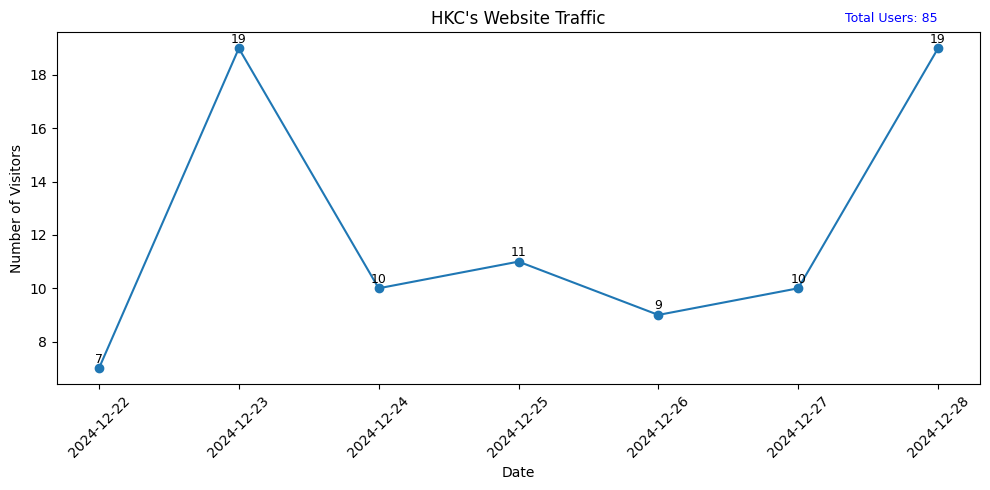

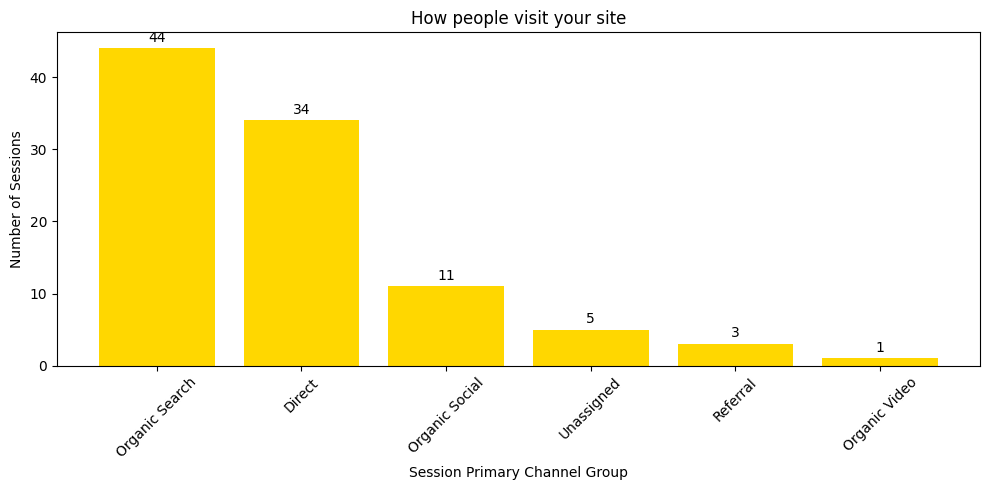

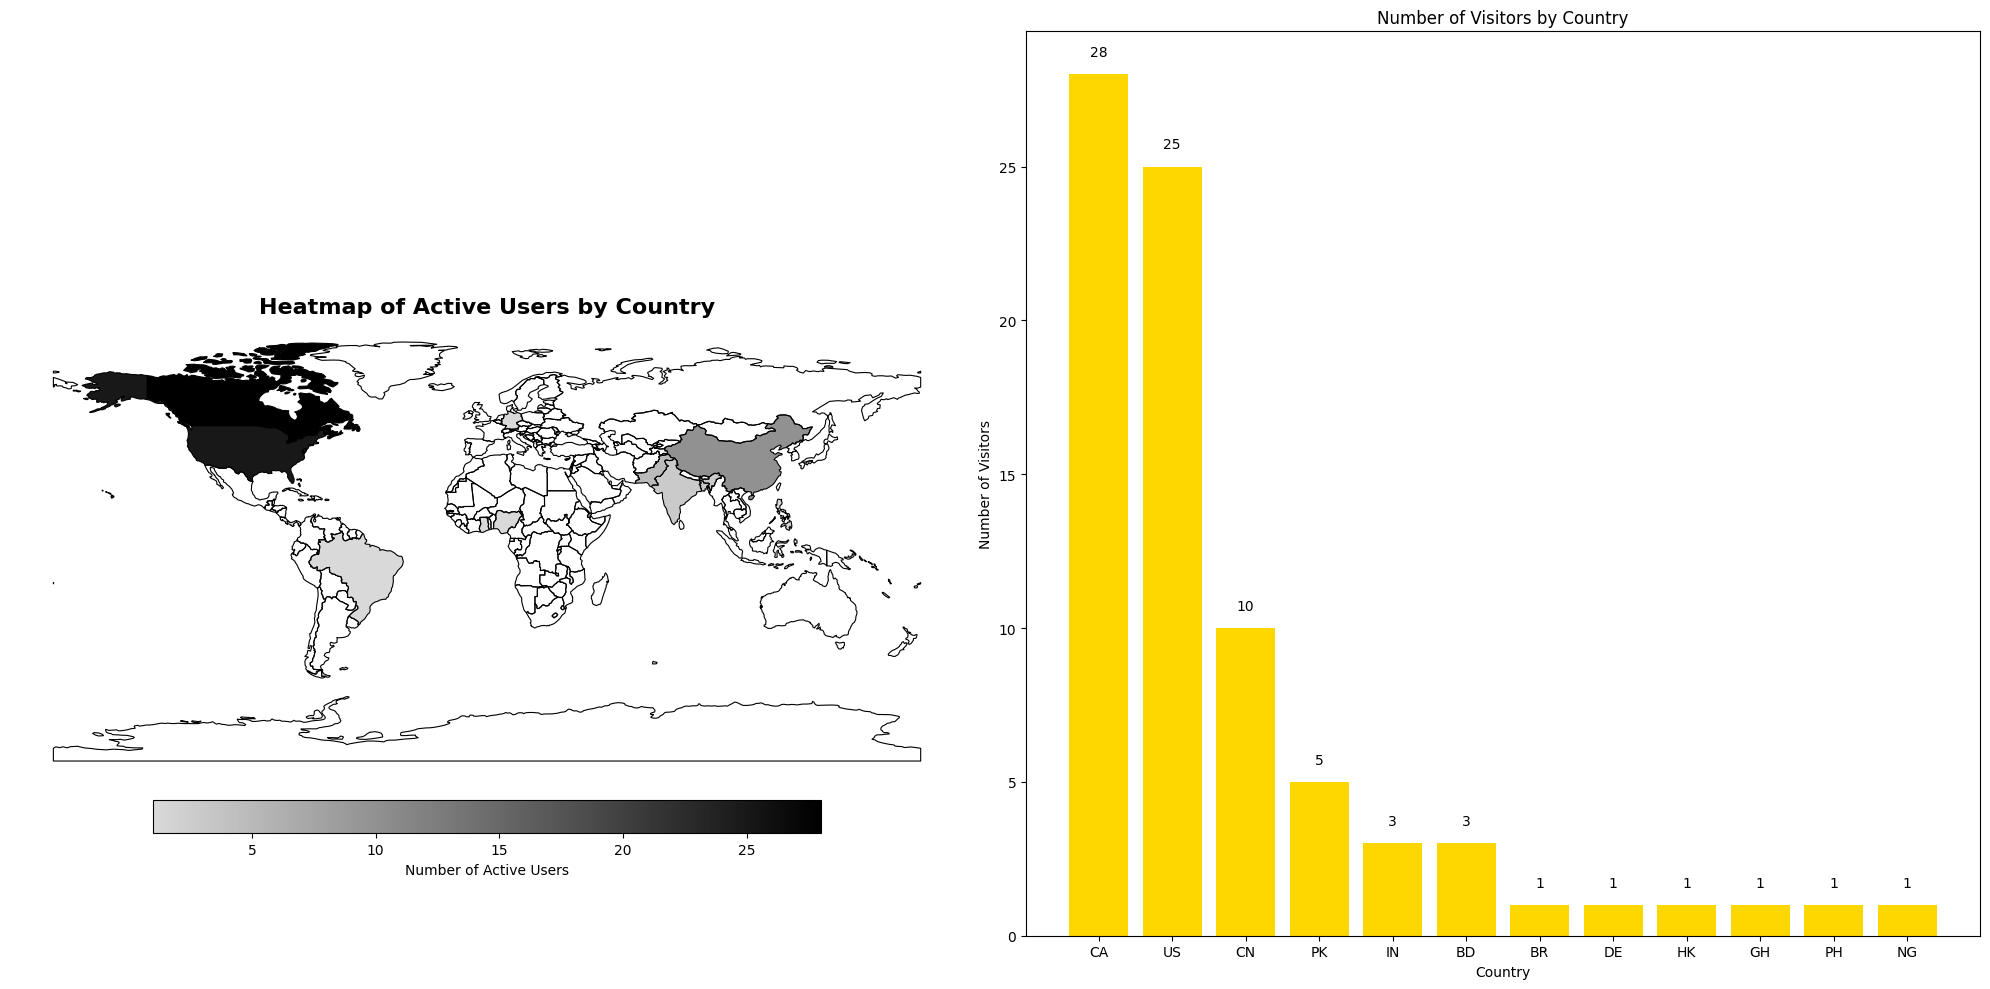

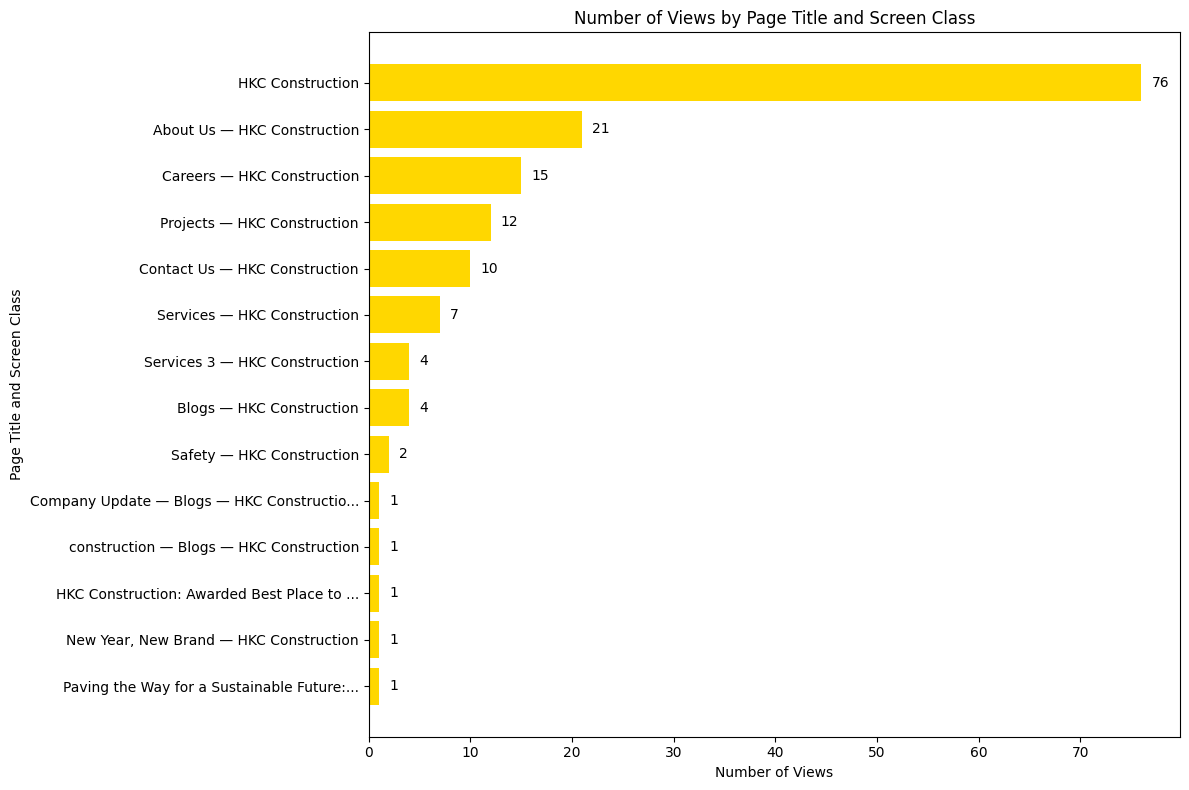

In [26]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pycountry
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display

# File upload widget
upload_widget = widgets.FileUpload(accept='.csv', multiple=False)
output_label = widgets.Label()

# Function to get the current year and week
def get_year_and_week():
    now = datetime.now()
    year = now.strftime("%Y")
    week_of_year = now.strftime("%U")
    return year, week_of_year

year, week = get_year_and_week()
# Create a new folder for plot images
output_folder = f"{year}-{week}-Website_Analytics"
os.makedirs(output_folder, exist_ok=True)

def process_file(change):
    # Check if a file was uploaded
    if not upload_widget.value:
        output_label.value = "Please upload a CSV file."
        return

    uploaded_file = list(upload_widget.value)[0]

    # ===================== Line Chart =====================
    with open(uploaded_file['name'], 'r') as file:
        lines = file.readlines()

    # Extract the start date and end date from the file content
    start_date = None
    end_date = None
    for line in lines:
        if line.startswith('# Start date:'):
            start_date = line.split(': ')[1].strip()
        if line.startswith('# End date:'):
            end_date = line.split(': ')[1].strip()
        if start_date and end_date:
            break

    # Find the index of the relevant section in the CSV file
    start_index = None
    for i, line in enumerate(lines):
        if line.startswith('Nth day,Active users'):
            start_index = i
            break

    # Load the relevant rows into a DataFrame
    df = pd.read_csv(uploaded_file['name'], skiprows=start_index, nrows=7, delimiter=',')
    dates = pd.date_range(start=start_date, end=end_date)
    active_users = df['Active users']

    # Calculate the total number of users
    total_users = active_users.sum()
    # Create a line chart
    plt.figure(figsize=(10, 5))
    plt.plot(dates, active_users, marker='o', label='Active Users')
    # Annotate each point with its value
    for i, (date, users) in enumerate(zip(dates, active_users)):
        plt.text(date, users + 0.1, str(users), fontsize=9, ha='center', va='bottom')
    
    # Annotate the total number of users
    plt.text(dates[-1], active_users.max() + 1, f'Total Users: {total_users}', 
            fontsize=9, ha='right', color='blue')

    plt.xlabel('Date')
    plt.ylabel('Number of Visitors')
    plt.title("HKC's Website Traffic")
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure
    output_path = os.path.join(output_folder, 'active_users_chart.png')
    plt.savefig(output_path)

    # ===================== Bar Chart =====================
    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith('Session primary channel group (Default Channel Group),Sessions'):
            start_index = i
        if start_index != None and line.strip() == "":
            end_index = i
            break
    df = pd.read_csv(uploaded_file['name'], skiprows=start_index, nrows=end_index - start_index-1, delimiter=',')
    session_groups = df['Session primary channel group (Default Channel Group)']
    sessions = df['Sessions'].fillna(0)

    plt.figure(figsize=(10, 5))
    bars = plt.bar(session_groups, sessions, color='gold')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    plt.xlabel('Session Primary Channel Group')
    plt.ylabel('Number of Sessions')
    plt.title('How people visit your site')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'top_campaigns.png'))

    # ===================== Heatmap and Bar Chart =====================
    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith('Country ID,Active users'):
            start_index = i
        if start_index != None and line.strip() == "":
            end_index = i
            break
    df = pd.read_csv(uploaded_file['name'], skiprows=start_index, nrows=end_index - start_index-1, delimiter=',')
    country_ids = df['Country ID']
    active_users = df['Active users']
    heatmap_data = pd.DataFrame({'Country ID': country_ids, 'Active users': active_users})
    world = gpd.read_file('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson')
    country_code_mapping = {country.alpha_2: country.alpha_3 for country in pycountry.countries}
    heatmap_data['Country ID'] = heatmap_data['Country ID'].map(country_code_mapping)
    world = world.merge(heatmap_data, how='left', left_on='ADM0_A3', right_on='Country ID')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_greys', ['#d9d9d9', '#000000'])

    # Set background color to white
    ax1.set_facecolor('white')

    # Plot the world boundaries
    world.boundary.plot(ax=ax1, linewidth=0.8, color='black')

    # Plot the data with the customized colormap
    world.plot(column='Active users',
            ax=ax1,
            legend=True,
            legend_kwds={
                'label': "Number of Active Users",
                'orientation': "horizontal",
                'shrink': 0.7,
                'pad': 0.02,
            },
            cmap=cmap,  # Customized colormap
            missing_kwds={
                "color": "white",
                "label": "No Data"
            })
    # Enhance the appearance
    ax1.set_title('Heatmap of Active Users by Country', fontsize=16, weight='bold')
    ax1.set_axis_off()

    df_sorted = df.sort_values(by='Active users', ascending=False)
    bars = ax2.bar(df_sorted['Country ID'], df_sorted['Active users'], color='gold')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    ax2.set_xlabel('Country')
    ax2.set_ylabel('Number of Visitors')
    ax2.set_title('Number of Visitors by Country')
    ax2.grid(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'heatmap_and_bar_chart.png'))

    # ===================== Horizontal Bar Chart =====================
    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith('Page title and screen class,Views'):
            start_index = i
            break
    df = pd.read_csv(uploaded_file['name'], skiprows=start_index, delimiter=',')
    page_titles = df['Page title and screen class']
    views = df['Views']
    data = pd.DataFrame({'Page Title': page_titles, 'Views': views})
    data_sorted = data.sort_values(by='Views', ascending=True)
    max_title_length = 40
    data_sorted['Page Title'] = data_sorted['Page Title'].apply(lambda x: x if len(x) <= max_title_length else x[:max_title_length] + '...')

    plt.figure(figsize=(12, 8))
    bars = plt.barh(data_sorted['Page Title'], data_sorted['Views'], color='gold')
    for bar in bars:
        xval = bar.get_width()
        plt.text(xval + 1, bar.get_y() + bar.get_height()/2, int(xval), va='center')
    plt.xlabel('Number of Views')
    plt.ylabel('Page Title and Screen Class')
    plt.title('Number of Views by Page Title and Screen Class')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'page_views_horizontal_bar_chart.png'))

    output_label.value = f"All plots have been saved to the folder: {output_folder}"

# Attach the event handler to the upload widget
upload_widget.observe(process_file, names='value')

# Display the UI
display(widgets.VBox([
    widgets.Label("Upload your CSV file:"),
    upload_widget,
    output_label
]))


## Operation V2

In [27]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import docx
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt
import PyPDF2
import datetime
import re

# Function to get the current year and week
def get_year_and_week():
    now = datetime.now()
    year = now.strftime("%Y")
    week_of_year = now.strftime("%U")
    return year, week_of_year

# Function to extract text from a DOCX file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    full_text = "\n".join([para.text for para in doc.paragraphs])
    
    table_data = []
    for table in doc.tables:
        for row in table.rows:
            row_data = [cell.text.strip() for cell in row.cells]
            table_data.append(row_data)
    
    return full_text, table_data

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        return "\n".join([page.extract_text() or "" for page in reader.pages])

# Function to extract details from text
def extract_details_from_text(text):
    patterns = {
        "project_name": r"Project Name[:\s]+([\w\s\-\d]+)",
        "prepared_by": r"Prepared By[:\s]+([\w\s]+)",
        "overall_progress": r"Overall Progress[:\s]+([\w\s\d%]+)",
        "current_phase": r"Current Phase[:\s]+([\w\s]+)",
        "spi": r"Schedule Performance Index \(SPI\)[:\s]+([\w\s\d\.\-]+)",
        "bpi": r"Budget Performance Index \(BPI\)[:\s]+([\w\s\d\.\-]+)"
    }
    extracted_details = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        extracted_details[key] = match.group(1).strip() if match else "Not Found"
    return extracted_details

# Function to extract details from tables
def extract_details_from_table(table_data):
    extracted_details = {
        "project_name": "Not Found",
        "prepared_by": "Not Found",
        "overall_progress": "Not Found",
        "current_phase": "Not Found",
        "spi": "Not Found",
        "bpi": "Not Found"
    }
    
    # Check each row for key-value pairs
    for row in table_data:
        if len(row) < 2:
            continue  # Skip rows that don't have at least 2 columns
        
        for i in range(len(row) - 1):
            key = row[i].strip().lower()
            value = row[i + 1].strip()
            
            if "project name" in key:
                extracted_details["project_name"] = value
            if "prepared by" in key:
                extracted_details["prepared_by"] = value
            if "overall progress" in key:
                extracted_details["overall_progress"] = value
            if "current phase" in key:
                extracted_details["current_phase"] = value
            if "schedule performance index" in key or "spi" in key:
                extracted_details["spi"] = value
            if "budget performance index" in key or "bpi" in key:
                extracted_details["bpi"] = value
    
    return extracted_details

# Function to create a combined Word document
def create_combined_docx(file_details):
    year, week = get_year_and_week()
    filename = f"{year}-{week}-Operations.docx"
    output_path = f"./{filename}"
    
    doc = docx.Document()
    for i, details in enumerate(file_details):
        doc.add_paragraph(f"File: {details['file_name']}", style='Heading1').alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
        doc.add_paragraph(f"Project Name: {details['project_name']}", style='Normal')
        doc.add_paragraph(f"Prepared By: {details['prepared_by']}", style='Normal')
        doc.add_paragraph(f"Overall Progress: {details['overall_progress']}", style='Normal')
        doc.add_paragraph(f"Current Phase: {details['current_phase']}", style='Normal')
        doc.add_paragraph(f"Schedule Performance Index (SPI): {details['spi']}", style='Normal')
        doc.add_paragraph(f"Budget Performance Index (BPI): {details['bpi']}", style='Normal')
        if i < len(file_details) - 1:
            doc.add_page_break()
    doc.save(output_path)
    print(f"\n✅ Combined Word document saved as: {output_path}")

# File upload widget
upload_widget = widgets.FileUpload(accept=".docx,.pdf", multiple=True)
process_button = widgets.Button(description="Process Files", button_style="success")
output_area = widgets.Output()

def process_files(change):
    if not upload_widget.value:
        with output_area:
            clear_output()
            print("No files uploaded. Please upload files to process.")
        return
    
    file_details = []
    for index, (name, *_) in enumerate(upload_widget.value):
        file_name = upload_widget.value[index][name]
        print(f"\nProcessing file: {file_name}")
        
        if file_name.endswith(".docx"):
            text, table_data = extract_text_from_docx(file_name)
            details = extract_details_from_table(table_data)
            text_details = extract_details_from_text(text)
            details.update({k: v for k, v in text_details.items() if v != "Not Found"})
        elif file_name.endswith(".pdf"):
            text = extract_text_from_pdf(file_name)
            details = extract_details_from_text(text)
        else:
            print(f"Unsupported file type: {file_name}")
            continue
        
        file_details.append({
            "file_name": file_name,
            **details
        })
    
    # Create a combined Word document
    create_combined_docx(file_details)

# Attach the processing function to the button
process_button.on_click(process_files)

# Display the UI
display(widgets.VBox([upload_widget, process_button, output_area]))



Processing file: Weekly Project Report of TWI- 2024-12-02 - 2024-12-06.docx

✅ Combined Word document saved as: ./2025-02-Operations.docx


C:\Users\Zey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\docx\styles\styles.py:130: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


## Merger

In [2]:
import os
import zipfile
from datetime import datetime
import glob

# Function to get the current year and week
def get_year_and_week():
    """Return the current year and week of the year as strings."""
    now = datetime.now()
    year = now.strftime("%Y")         # Current year
    week_of_year = now.strftime("%U") # Week number of the year
    return year, week_of_year

# Function to collect files based on the naming convention
def collect_files_and_folders(output_dir, prefix):
    """Collect files and all files in directories that match the naming convention."""
    print(f"Looking for files and folders with prefix: {prefix}")  # Debug: Show prefix

    # Collect matching files
    file_search_pattern = os.path.join(output_dir, f"{prefix}*")  # Match files starting with the prefix
    matched_files = glob.glob(file_search_pattern)
    print(f"Matched files: {matched_files}")  # Debug: List matched files

    # Collect all files from matched folders
    matched_folders = [path for path in matched_files if os.path.isdir(path)]
    all_files_in_folders = []
    for folder in matched_folders:
        print(f"Collecting files from folder: {folder}")  # Debug: Show folder being processed
        for root, _, files in os.walk(folder):
            for file in files:
                full_path = os.path.join(root, file)
                all_files_in_folders.append(full_path)

    print(f"All files in matched folders: {all_files_in_folders}")  # Debug: List all files in folders

    # Combine files directly matching the prefix and files from matched folders
    all_files = [f for f in matched_files if os.path.isfile(f)] + all_files_in_folders
    print(f"Total files collected: {all_files}")  # Debug: Show all collected files
    return all_files

# Function to create a zip file
def create_zip_file(file_list, zip_filename):
    """Create a zip file containing the specified files."""
    with zipfile.ZipFile(zip_filename, 'w') as zf:
        for file in file_list:
            # Use relative path for folder structure preservation
            arcname = os.path.relpath(file, os.getcwd())
            zf.write(file, arcname)
    print(f"Zip file {zip_filename} created with {len(file_list)} files.")

# Main execution
output_dir = os.getcwd()  # Default directory where the notebook is saved
year, week = get_year_and_week()
file_prefix = f"{year}-{week}-"  # Example prefix: "2024-51-"
zip_filename = f"{year}_{week}_Final_Dev_Report.zip"  # Naming of the zip file

try:
    # Collect files and folder contents following the naming convention
    matching_files = collect_files_and_folders(output_dir, file_prefix)

    # If no matching files are found, exit gracefully
    if not matching_files:
        print(f"No files or folders found matching the prefix {file_prefix} in {output_dir}.")
    else:
        # Create a zip file containing the matching files
        create_zip_file(matching_files, zip_filename)
        print(f"Files and folders matching the prefix {file_prefix} have been zipped into {zip_filename}.")
except Exception as e:
    print(f"Error: {e}")


Looking for files and folders with prefix: 2025-01-
Matched files: ['c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Estimation.txt', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Marketing-Zoho_Campaign-Introduction.txt', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Operations.docx', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Safety-Peel_Living_-_Ceiling_Removal.txt', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-SocialmediaReports.png', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Website_Analytics']
All files in matched folders: ['c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Website_Analytics\\2025-01-active_users_chart.png', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Website_Analytics\\heatmap_and_bar_chart.png', 'c:\\Users\\Zey\\Downloads\\Report-Generator\\Code\\2025-01-Website_Analytics\\page_views_horizontal_bar_chart.png', 'c:\\Users\\Zey\\Downloads\\Report-Gene

## PDF Merger

In [14]:
import os
from fpdf import FPDF
from PyPDF2 import PdfMerger
from PIL import Image
import comtypes.client
import ipywidgets as widgets
from IPython.display import display, clear_output

# Functions for file processing
def add_text_as_page(pdf, text):
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, text)

def txt_to_pdf_single_page(txt_file, pdf_file):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    # Read the text file
    with open(txt_file, "r", encoding="utf-8") as file:
        text = file.read()

    # Add the entire content to the PDF on a single page
    pdf.multi_cell(0, 10, text)

    # Save the PDF
    pdf.output(pdf_file)
    return pdf_file

def image_to_pdf(image_file):
    img = Image.open(image_file)
    pdf_path = image_file + ".pdf"
    img.convert('RGB').save(pdf_path)
    return pdf_path

def merge_pdfs(pdfs):
    merger = PdfMerger()
    for pdf in pdfs:
        merger.append(pdf)
    output_path = "merged_output.pdf"
    merger.write(output_path)
    merger.close()
    return output_path

def process_files_and_text(files, file_order):
    pdfs = []
    temp_files = []  # List to track temporary files for cleanup

    for file_name in file_order:
        file = next(f for f in files if f['name'] == file_name)
        file_name, file_extension = os.path.splitext(file['name'])
        
        if file_extension.lower() == ".pdf":
            pdfs.append(file['path'])
        
        elif file_extension.lower() == ".txt":
            output = txt_to_pdf_single_page(file['path'], file_name + ".pdf")
            pdfs.append(output)
            temp_files.append(output)  # Track temporary file
        
        elif file_extension.lower() == ".docx":
            try:
                if not os.path.exists(file['path']):
                    raise FileNotFoundError(f"Word file not found: {file['path']}")

                output_path = os.path.abspath(f"{file_name}.pdf")
                wdFormatPDF = 17
                word = comtypes.client.CreateObject("Word.Application")
                doc = word.Documents.Open(os.path.abspath(file['path']))
                doc.SaveAs(output_path, FileFormat=wdFormatPDF)
                doc.Close()
                word.Quit()

                if os.path.exists(output_path):
                    pdfs.append(output_path)
                    temp_files.append(output_path)  # Track temporary file
                else:
                    print(f"Error: Failed to create PDF for {file['name']}.")
            except Exception as e:
                print(f"Error processing Word file {file['name']}: {e}")

        elif file_extension.lower() in [".png", ".jpg", ".jpeg"]:
            pdf_output = image_to_pdf(file['path'])
            pdfs.append(pdf_output)
            temp_files.append(pdf_output)  # Track temporary file

    # Merge PDFs
    merged_pdf = merge_pdfs(pdfs)

    # Cleanup: Remove temporary files
    for temp_file in temp_files:
        try:
            os.remove(temp_file)
            print(f"Temporary file deleted: {temp_file}")
        except Exception as e:
            print(f"Error deleting temporary file {temp_file}: {e}")

    return merged_pdf


# UI Components using ipywidgets
file_upload = widgets.FileUpload(accept=".pdf,.txt,.docx,.png,.jpg,.jpeg", multiple=True)
file_list_display = widgets.Textarea(
    description="Uploaded Files:",
    layout=widgets.Layout(width='100%', height='150px'),
    disabled=True
)
file_index_dropdown = widgets.Dropdown(
    options=[],
    description="Select File:",
    layout=widgets.Layout(width="50%")
)
move_up_button = widgets.Button(description="Move Up", button_style="info")
move_down_button = widgets.Button(description="Move Down", button_style="info")
merge_button = widgets.Button(description="Merge Files", button_style="success")
output_area = widgets.Output()

# State management
uploaded_files = []
file_order = []

def handle_file_upload(change):
    global uploaded_files, file_order
    uploaded_files = []
    file_order = []

    for file_info in file_upload.value:
        name = file_info['name']
        file_path = os.path.join(os.getcwd(), name)
        with open(file_path, "wb") as f:
            f.write(file_info['content'])
        uploaded_files.append({'name': name, 'path': file_path})
        file_order.append(name)
    update_file_list()

def update_file_list(selected_index=None):
    file_list_display.value = "\n".join(file_order)
    file_index_dropdown.options = [(name, idx) for idx, name in enumerate(file_order)]
    if selected_index is not None and 0 <= selected_index < len(file_order):
        file_index_dropdown.value = selected_index

def move_file(direction):
    global file_order
    selected_index = file_index_dropdown.value
    if selected_index is None or not (0 <= selected_index < len(file_order)):
        with output_area:
            clear_output()
            print("Invalid selection. Please select a valid file.")
        return

    if direction == "up" and selected_index > 0:
        file_order[selected_index], file_order[selected_index - 1] = (
            file_order[selected_index - 1],
            file_order[selected_index],
        )
        update_file_list(selected_index - 1)  # Update dropdown to reflect new position

    elif direction == "down" and selected_index < len(file_order) - 1:
        file_order[selected_index], file_order[selected_index + 1] = (
            file_order[selected_index + 1],
            file_order[selected_index],
        )
        update_file_list(selected_index + 1)  # Update dropdown to reflect new position


def merge_files(change):
    with output_area:
        clear_output()
        if not uploaded_files:
            print("No files to process!")
            return

        print("Processing files...")
        merged_pdf = process_files_and_text(uploaded_files, file_order)
        print(f"Merged PDF created: {merged_pdf}")

file_upload.observe(handle_file_upload, names="value")
move_up_button.on_click(lambda x: move_file("up"))
move_down_button.on_click(lambda x: move_file("down"))
merge_button.on_click(merge_files)

ui = widgets.VBox([
    widgets.Label("File Merger: Merge PDF, TXT, DOCX, and Image files into a single PDF."),
    file_upload,
    file_list_display,
    widgets.HBox([file_index_dropdown, move_up_button, move_down_button]),
    merge_button,
    output_area
])

display(ui)
